In [ ]:
# default_exp fit

# neos.fit

> Module that wraps constrained + global fitters in a differentiable form using the module fax. Uses the two-phase-solver.

In [ ]:
# export
import jax
from fax.implicit import twophase
import jax.experimental.optimizers as optimizers

from neos.transforms import to_bounded_vec, to_inf_vec, to_bounded, to_inf
from neos.models import *

In [ ]:
#export
def get_solvers(
    model_constructor,
    pdf_transform=False,
    default_rtol=1e-10,
    default_atol=1e-10,
    default_max_iter=int(1e7),
    learning_rate = 0.01
):

    adam_init, adam_update, adam_get_params  = optimizers.adam(1e-6)

    def make_model(hyper_pars):
        constrained_mu, nn_pars = hyper_pars[0], hyper_pars[1]
        m, bonlypars = model_constructor(nn_pars)


        bounds = m.config.suggested_bounds
        constrained_mu = to_inf(constrained_mu,bounds[0]) if pdf_transform else constrained_mu

        exp_bonly_data = expected_data(m,bonlypars, include_auxdata=True)

        def expected_logpdf(pars):  # maps pars to bounded space if pdf_transform = True

            return (
                logpdf(
                    m,to_bounded_vec(pars, bounds), exp_bonly_data
                )
                if pdf_transform
                else
                logpdf(
                    m,pars, exp_bonly_data
                )
            )

        def global_fit_objective(pars):  # NLL
            return -expected_logpdf(pars)[0]

        def constrained_fit_objective(nuis_par):  # NLL
            pars = jax.numpy.concatenate(
                [jax.numpy.asarray([constrained_mu]), nuis_par]
            )
            return -expected_logpdf(pars)[0]

        return constrained_mu, global_fit_objective, constrained_fit_objective,bounds

    def global_bestfit_minimized(hyper_param):
        _, nll, _ ,_ = make_model(hyper_param)

        def bestfit_via_grad_descent(i, param):  # gradient descent
            g = jax.grad(nll)(param)
            # param = param - g * learning_rate
            param = adam_get_params(adam_update(i,g,adam_init(param)))
            return param

        return bestfit_via_grad_descent

    def constrained_bestfit_minimized(hyper_param):
        mu, nll, cnll,bounds = make_model(hyper_param)

        def bestfit_via_grad_descent(i, param):  # gradient descent
            _, np = param[0], param[1:]
            g = jax.grad(cnll)(np)
            np = adam_get_params(adam_update(i,g,adam_init(np)))
            param = jax.numpy.concatenate([jax.numpy.asarray([mu]), np])
            return param

        return bestfit_via_grad_descent

    global_solve = twophase.two_phase_solver(
        param_func=global_bestfit_minimized,
        default_rtol=default_rtol,
        default_atol=default_atol,
        default_max_iter=default_max_iter
    )
    constrained_solver = twophase.two_phase_solver(
        param_func=constrained_bestfit_minimized,
        default_rtol=default_rtol,
        default_atol=default_atol,
        default_max_iter=default_max_iter,
    )

    def g_fitter(init, hyper_pars):
        solve = global_solve(init, hyper_pars)
        return solve.value

    def c_fitter(init, hyper_pars):
        solve = constrained_solver(init, hyper_pars)
        return solve.value

    return g_fitter, c_fitter

#### getting test

In [ ]:
from neos.models import nn_model_maker

g_fitter, c_fitter = get_solvers(nn_model_maker)

#### non-transformed fit test


Starting training...
Epoch 0 in 4.47 sec
Training set accuracy 0.8476
model: [ 6.40477037 13.59522963],[43.13707402  6.86292598],[4.44113382 4.44113382]
model: Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>,Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>,Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>
global fit: [1.53910115e-06 1.00000158e+00]


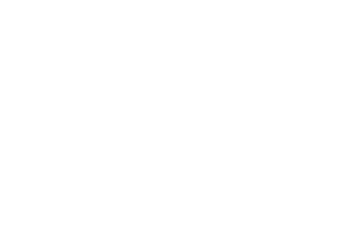

In [ ]:
from neos.nn import three_blob_classifier

x = three_blob_classifier()
_ = x.train(num_epochs=1)
nn_params = x.params

g_fitter, c_fitter = get_solvers(nn_model_maker, pdf_transform=False)

m, bonlypars = nn_model_maker(nn_params)
exp_data = m.expected_data(bonlypars)
bounds = m.config.suggested_bounds

test_mu = 1.0

# map these
initval = jax.numpy.asarray([test_mu, 1.0])
# the constrained fit
#numerator = c_fitter(initval, [test_mu, nn_params])
# the global fit
denominator = g_fitter(initval, [test_mu, nn_params])

#print(f"constrained fit: {numerator}")
print(f"global fit: {denominator}")

#print(f"transformed constrained fit: {transform_lim_vec(numerator,bounds)}")
#print(f"transformed global fit: {transform_lim_vec(denominator,bounds)}")

#### transformed fit test

In [ ]:
g_fitter, c_fitter = get_solvers(nn_model_maker, pdf_transform=True)

m, bonlypars = nn_model_maker(nn_params)
exp_data = m.expected_data(bonlypars)
bounds = m.config.suggested_bounds()

test_mu = .5

initval = jax.numpy.asarray([test_mu, 1.0])

# transform everything to inf space
initval = to_inf_vec(initval, bounds)
init_test_mu = to_inf(test_mu, bounds[0])

# do fits, then transform answers to bounded space
#numerator = to_bounded_vec(c_fitter(initval, [init_test_mu, nn_params]), bounds)
denominator = to_bounded_vec(g_fitter(initval, [init_test_mu, nn_params]), bounds)

#print(f"constrained fit: {numerator}")
print(f"global fit: {denominator}")

model: [ 6.40477037 13.59522963],[43.13707402  6.86292598],[4.44113382 4.44113382]
model: Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>,Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>,Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>
global fit: [0.         1.00000474]
